<a href="https://colab.research.google.com/github/shrisrivas/Project_Data_labelling_chest_images/blob/main/Data_labelling_chest_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Use this Notebook on Google Colab Free GPU**
Go to Google Drive, upload this notebook and dataset folders. Rigth click notebook, choose **Open with -> Google Colab**
<br>
To activate GPU in Colab, go to **Runtime -> Change Runtime Type**. Under **Hardware accelerator** choose **GPU**

### Connect to Google Drive to access Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/1. chest_x-ray'

Mounted at /content/drive
/content/drive/MyDrive/1. chest_x-ray


In [3]:
%ls

class/  diseases/  model.png  shristi/


### Import all dependencies

In [4]:
from __future__ import print_function, division
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob

In [5]:
import os
os.listdir()

['diseases', 'shristi', 'model.png', 'class']

Data preparation


In [35]:
import os
import glob
import shutil

source = '/content/drive/MyDrive/1. chest_x-ray/diseases'
destination = '/content/drive/MyDrive/1. chest_x-ray/class/COVID'
#
# gather all files
allfiles = glob.glob(os.path.join(source, 'C*'), recursive=True)
print("Files to move", allfiles)

# iterate on all files to move them to destination folder
for file_path in allfiles:
	dst_path = os.path.join(destination, os.path.basename(file_path))
	shutil.move(file_path, dst_path)
	print(f"Moved {file_path} -> {dst_path}")


Files to move []


In [7]:
# os.mkdir('NORMAL')
# os.mkdir('PNEUMONIA')

In [8]:
os.listdir()

['diseases', 'shristi', 'model.png', 'class']

In [36]:
source = '/content/drive/MyDrive/1. chest_x-ray/diseases'
destination = '/content/drive/MyDrive/1. chest_x-ray/class/NORMAL'
#
# gather all files
allfiles = glob.glob(os.path.join(source, 'N*'), recursive=True)
print("Files to move", allfiles)

# iterate on all files to move them to destination folder
for file_path in allfiles:
	dst_path = os.path.join(destination, os.path.basename(file_path))
	shutil.move(file_path, dst_path)
	print(f"Moved {file_path} -> {dst_path}")

Files to move []


In [37]:
source = '/content/drive/MyDrive/1. chest_x-ray/diseases'
destination = '/content/drive/MyDrive/1. chest_x-ray/class/PNEUMONIA'
#
# gather all files
allfiles = glob.glob(os.path.join(source, 'P*'), recursive=True)
print("Files to move", allfiles)

# iterate on all files to move them to destination folder
for file_path in allfiles:
	dst_path = os.path.join(destination, os.path.basename(file_path))
	shutil.move(file_path, dst_path)
	print(f"Moved {file_path} -> {dst_path}")

Files to move []


In [11]:
os.listdir()

['diseases', 'shristi', 'model.png', 'class']

In [12]:
# these can be set using env by requirement.txt
# !pip install matplotlib==3.3.3
# !pip install pandas==1.1.5
# !pip install mlxtend==0.18.0
# !pip install tensorflow==2.4.0
# !pip install numpy==1.19.5
# !pip install opencv_python==4.5.1.48
# !pip install psutil==5.7.3
# !pip install Pillow==8.1.0
# !pip install scikit_learn==0.24.1

In [13]:
import re
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE
# from kaggle_datasets import KaggleDatasets
# Detect hardware, return appropriate distribution strategy

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

Tensorflow version 2.9.2
REPLICAS:  1


In [14]:
if tpu:
  BATCH_SIZE = 16*strategy.num_replicas_in_sync  # A TPU has 8 cores so this will be 128
else:
  BATCH_SIZE = 32  # On Colab/GPU, a higher batch size does not help and sometimes does not fit on the GPU (OOM)


BATCH_SIZE = 16 * strategy.num_replicas_in_sync # this is 8 on TPU v3-8, it is 1 on CPU and GPU
LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)



### Define Few Parameters

In [38]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224] # feel free to change depending on dataset

# training config:
epochs = 500
batch_size = 32

#define paths
covid_path = '/content/drive/MyDrive/1. chest_x-ray/class/COVID/*.*'
normal_path = '/content/drive/MyDrive/1. chest_x-ray/class/NORMAL/*.*'
pneumonia_path = '/content/drive/MyDrive/1. chest_x-ray/class/PNEUMONIA/*.*'

# Use glob to grab images from path .jpg or jpeg
covid_files = glob.glob(covid_path )
normal_files = glob.glob(normal_path  )
pneumonia_files = glob.glob(pneumonia_path )

In [39]:
print(covid_files) #print the list containing files name

['/content/drive/MyDrive/1. chest_x-ray/class/COVID/COVID_10.png', '/content/drive/MyDrive/1. chest_x-ray/class/COVID/COVID_103.png', '/content/drive/MyDrive/1. chest_x-ray/class/COVID/COVID_100.png', '/content/drive/MyDrive/1. chest_x-ray/class/COVID/COVID_102.png', '/content/drive/MyDrive/1. chest_x-ray/class/COVID/COVID_101.png', '/content/drive/MyDrive/1. chest_x-ray/class/COVID/COVID.png', '/content/drive/MyDrive/1. chest_x-ray/class/COVID/COVID_105.png', '/content/drive/MyDrive/1. chest_x-ray/class/COVID/COVID_106.png', '/content/drive/MyDrive/1. chest_x-ray/class/COVID/COVID_104.png', '/content/drive/MyDrive/1. chest_x-ray/class/COVID/COVID_107.png', '/content/drive/MyDrive/1. chest_x-ray/class/COVID/COVID_111.png', '/content/drive/MyDrive/1. chest_x-ray/class/COVID/COVID_110.png', '/content/drive/MyDrive/1. chest_x-ray/class/COVID/COVID_108.png', '/content/drive/MyDrive/1. chest_x-ray/class/COVID/COVID_109.png', '/content/drive/MyDrive/1. chest_x-ray/class/COVID/COVID_11.png', 

In [40]:
# Visualize file variable contents
print("First 5 Covid Files: ",covid_files[0:5])
print("Total Count: ",len(covid_files))
print("First 5 normal Files: ",normal_files[0:5])
print("Total Count: ",len(normal_files))
print("First 5 pneumonia Files: ", pneumonia_files[0:5])
print("Total Count: ",len(pneumonia_files))

First 5 Covid Files:  ['/content/drive/MyDrive/1. chest_x-ray/class/COVID/COVID_10.png', '/content/drive/MyDrive/1. chest_x-ray/class/COVID/COVID_103.png', '/content/drive/MyDrive/1. chest_x-ray/class/COVID/COVID_100.png', '/content/drive/MyDrive/1. chest_x-ray/class/COVID/COVID_102.png', '/content/drive/MyDrive/1. chest_x-ray/class/COVID/COVID_101.png']
Total Count:  300
First 5 normal Files:  ['/content/drive/MyDrive/1. chest_x-ray/class/NORMAL/NORMAL_100.png', '/content/drive/MyDrive/1. chest_x-ray/class/NORMAL/NORMAL.png', '/content/drive/MyDrive/1. chest_x-ray/class/NORMAL/NORMAL_101.png', '/content/drive/MyDrive/1. chest_x-ray/class/NORMAL/NORMAL_10.png', '/content/drive/MyDrive/1. chest_x-ray/class/NORMAL/NORMAL_104.png']
Total Count:  300
First 5 pneumonia Files:  ['/content/drive/MyDrive/1. chest_x-ray/class/PNEUMONIA/PNEUMONIA.png', '/content/drive/MyDrive/1. chest_x-ray/class/PNEUMONIA/PNEUMONIA_10.png', '/content/drive/MyDrive/1. chest_x-ray/class/PNEUMONIA/PNEUMONIA_101.pn

In [18]:
covid_path

'/content/drive/MyDrive/1. chest_x-ray/COVID/*.*'

### Fetch Images and Class Labels from Files (This might take a while)

In [41]:
# Preparing Labels
covid_labels = []
normal_labels = []
pneumonia_labels = []

covid_images=[]
normal_images=[]
pneumonia_images =[]

import cv2 

for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  print(covid_images.append(image))
  print(covid_labels.append('Chest_COVID'))
for i in range(len(normal_files)):
  image = cv2.imread(normal_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  normal_images.append(image)
  normal_labels.append('Chest_Normal')
for i in range(len(pneumonia_files)):
  image = cv2.imread(pneumonia_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  pneumonia_images.append(image)
  pneumonia_labels.append('Chest_pneumonia')

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


### Visualize First 40 Images from Data set

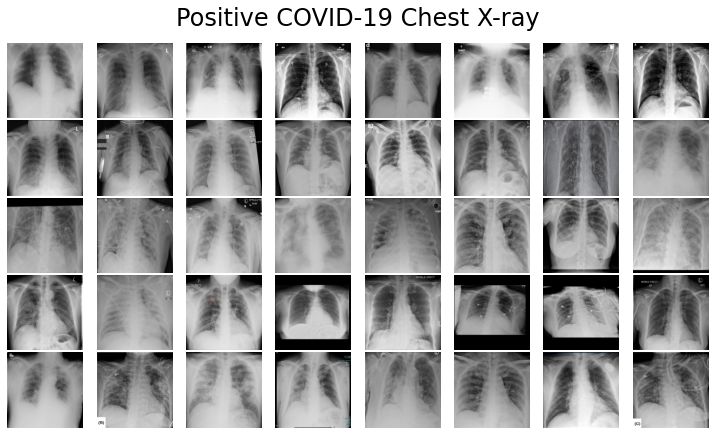

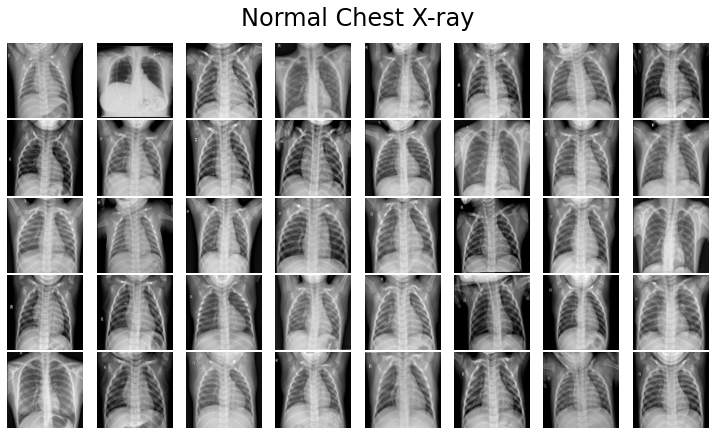

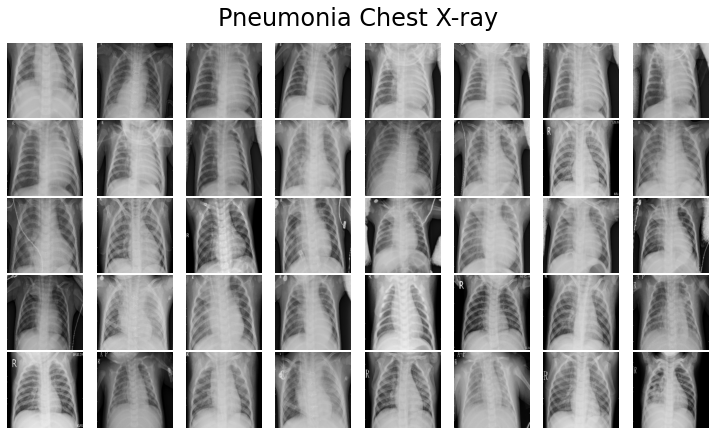

In [42]:
# look at a random image for fun
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_images, 'Positive COVID-19 Chest X-ray')
plot_images(normal_images, 'Normal Chest X-ray')
plot_images(pneumonia_images, 'Pneumonia Chest X-ray')

In [ ]:
covid_images

### **Normalization**
#### Model takes images in the form of array of pixels. Hence convert into array and *normalize*

In [21]:
# normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255
normal_images = np.array(normal_images) / 255
pneumonia_images = np.array(pneumonia_images) / 255

### **Train Test Split**

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_data_dir='/content/drive/MyDrive/1. chest_x-ray/class'
batch_size=32
train_datagen = ImageDataGenerator(
      validation_split=0.2) 

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') 
# set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, 
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') 
# set as validation data

Found 720 images belonging to 3 classes.
Found 180 images belonging to 3 classes.


### **Building and Visualizing model**

In [24]:
inception = InceptionV3(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = inception.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(3, activation="softmax")(outputs)

model = Model(inputs=inception.input, outputs=outputs)

for layer in inception.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

87910968/87910968 [==============================] - 3s 0us/step


In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

### **Training the model**

In [26]:
history=model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = 20)

<ipython-input-26-efee5f517b59>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(


Epoch 1/20
22/22 [==============================] - 265s 11s/step - loss: 47.1109 - accuracy: 0.7529 - val_loss: 17.3129 - val_accuracy: 0.9187
Epoch 2/20
22/22 [==============================] - 3s 148ms/step - loss: 16.4621 - accuracy: 0.8866 - val_loss: 31.4107 - val_accuracy: 0.8188
Epoch 3/20
22/22 [==============================] - 3s 148ms/step - loss: 11.3908 - accuracy: 0.8977 - val_loss: 13.8611 - val_accuracy: 0.9438
Epoch 4/20
22/22 [==============================] - 3s 149ms/step - loss: 6.1633 - accuracy: 0.9332 - val_loss: 13.3582 - val_accuracy: 0.9312
Epoch 5/20
22/22 [==============================] - 3s 148ms/step - loss: 3.7388 - accuracy: 0.9448 - val_loss: 10.4378 - val_accuracy: 0.9688
Epoch 6/20
22/22 [==============================] - 3s 148ms/step - loss: 5.9452 - accuracy: 0.9318 - val_loss: 24.7681 - val_accuracy: 0.8625
Epoch 7/20
22/22 [==============================] - 3s 149ms/step - loss: 7.1910 - accuracy: 0.9317 - val_loss: 20.3318 - val_accuracy: 0.9

In [27]:
model.save('inceptionv3_chest.h5')

In [28]:
model.save_weights('inceptionv3_chest.hdf5')

In [29]:
model = load_model('inceptionv3_chest.h5')

### **Calculating accuracy**

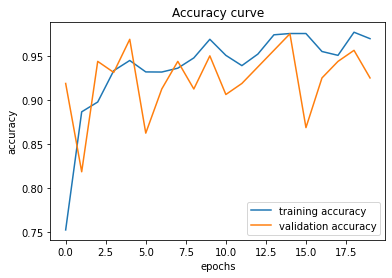

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(acc, label='training accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.title('Accuracy curve')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

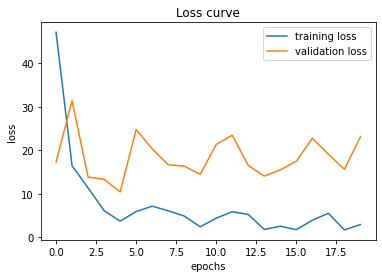

In [31]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='training loss')
plt.plot(val_loss, label='validation loss')
plt.title('Loss curve')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

Conclusion
We have created a dataset with covid xray images from given database of 1000 images with three main class- normal, pnemonia and covid. We used Inceptionv3 model for the classification of the dataset

We have obtained accuracy of about 98% while testing the whole dataset. 

